### Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize # type: ignore
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence # type: ignore
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [2]:
df = pd.read_csv('umich_train_data.csv', header=None, delimiter='\t', quoting=3)
df.columns = ['sentiment','text']
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape

(30459, 2)

In [3]:
df.head()

,sentiment,text
0,0,The history here goes back to the summer of 19...
1,0,American Express customer service SUCKS...
2,1,"Wow, having XP on my MacBook would be awesome..."
3,1,"I love paris hilton, britney spears and jessic..."
4,1,"The Da Vinci Code was awesome, I can't wait to..."


### Data Visualization and Preprocessing

In [4]:
df.head()

,sentiment,text
0,0,The history here goes back to the summer of 19...
1,0,American Express customer service SUCKS...
2,1,"Wow, having XP on my MacBook would be awesome..."
3,1,"I love paris hilton, britney spears and jessic..."
4,1,"The Da Vinci Code was awesome, I can't wait to..."


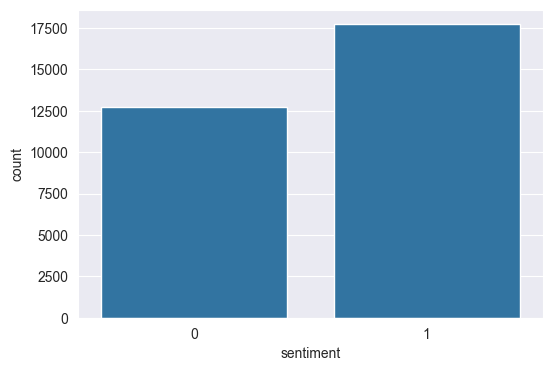

In [5]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(x=df.sentiment, data=df)
plt.show()

Slight imbalance is observed in the classes of target variable

In [6]:
df.isna().sum() # Checking for nan Values

sentiment    0
text         0
dtype: int64

### Cleaning the corpus

In [7]:
def clean_text(text):
    text = str(text).lower() ## Make text lowercase
    text = re.sub('\[.*?\]', '', text) ## remove any sequence of characters in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) ## remove links
    text = re.sub('<.*?>+', '', text) ## remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) ## remove punctuation
    text = re.sub('\n', '', text) ## remove newline characters 
    text = re.sub('\w*\d\w*', '', text) ## remove words containing numbers
    return text

In [8]:
df['text_clean'] = df['text'].apply(clean_text)
df.head()

,sentiment,text,text_clean
0,0,The history here goes back to the summer of 19...,the history here goes back to the summer of w...
1,0,American Express customer service SUCKS...,american express customer service sucks
2,1,"Wow, having XP on my MacBook would be awesome...",wow having xp on my macbook would be awesome
3,1,"I love paris hilton, britney spears and jessic...",i love paris hilton britney spears and jessica...
4,1,"The Da Vinci Code was awesome, I can't wait to...",the da vinci code was awesome i cant wait to r...


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Anubhav
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,sentiment,text,text_clean
0,0,The history here goes back to the summer of 19...,history goes back summer san francisco giants...
1,0,American Express customer service SUCKS...,american express customer service sucks
2,1,"Wow, having XP on my MacBook would be awesome...",wow xp macbook would awesome
3,1,"I love paris hilton, britney spears and jessic...",love paris hilton britney spears jessica simpson
4,1,"The Da Vinci Code was awesome, I can't wait to...",da vinci code awesome cant wait read


In [11]:
len(stop_words)

182

In [12]:
df = df.drop('text', axis=1)
df = df.rename(columns={'text_clean': 'text'})
df.head()

,sentiment,text
0,0,history goes back summer san francisco giants...
1,0,american express customer service sucks
2,1,wow xp macbook would awesome
3,1,love paris hilton britney spears jessica simpson
4,1,da vinci code awesome cant wait read


In [13]:
df2 = df.copy()

### WordCloud

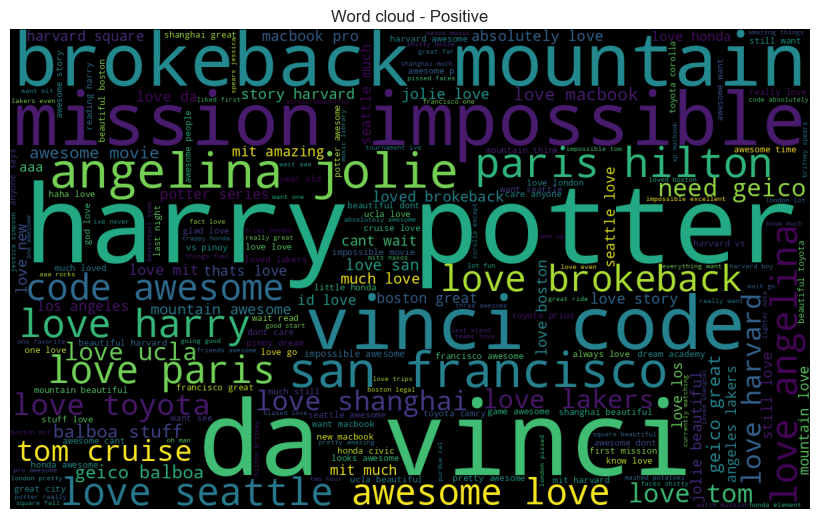

In [14]:
#dfs = df.sample(frac=0.1, random_state=42)

wrds=''
for msg in df[df['sentiment']==1]['text']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '
        
wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - Positive')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

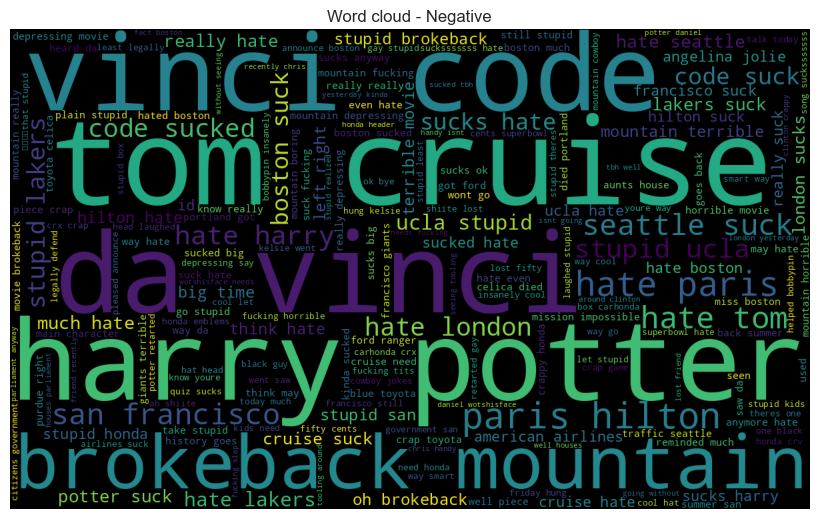

In [15]:
wrds=''
for msg in df[df['sentiment']==0]['text']:
    msg=msg.split()
    for words in msg:
        wrds = wrds+words+' '
        
wcloud = WordCloud(width=1200, height=720,random_state=101).generate(wrds)

plt.figure( figsize=(10,5), facecolor='w')
plt.imshow(wcloud)
plt.title('Word cloud - Negative')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Number of words in each text**

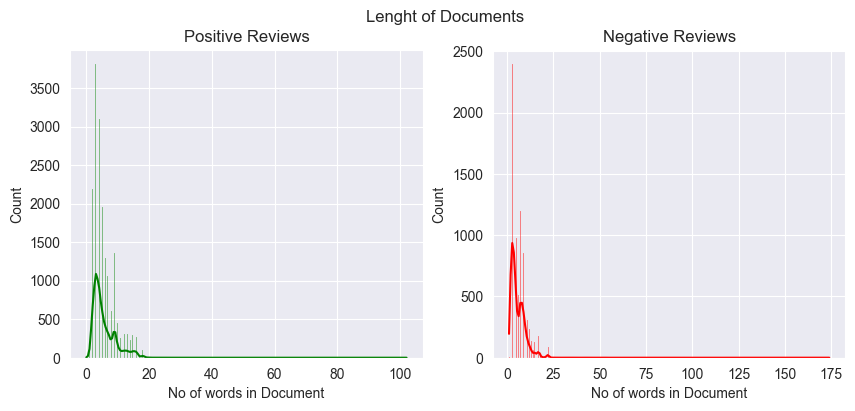

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Distribution plot for Positive Reviews
text_len_positive = df[df['sentiment'] == 1]['text'].str.split().map(lambda x: len(x))
sns.histplot(text_len_positive, kde=True, color='green', ax=ax1)
ax1.set_title('Positive Reviews')
ax1.set_xlabel('No of words in Document')

# Distribution plot for Negative Reviews
text_len_negative = df[df['sentiment'] == 0]['text'].str.split().map(lambda x: len(x))
sns.histplot(text_len_negative, kde=True, color='red', ax=ax2)
ax2.set_title('Negative Reviews')
ax2.set_xlabel('No of words in Document')

fig.suptitle('Lenght of Documents')
plt.show()

Negative Reviews are generally more in length as apparent from the above distribution plots.

### Word Frequency

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

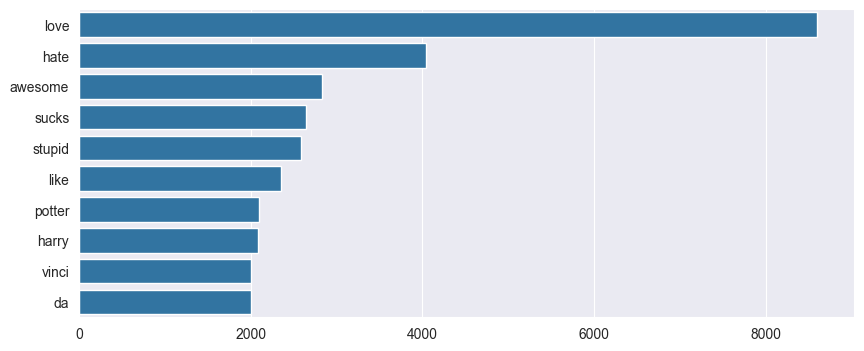

In [18]:
plt.figure(figsize = (10,4))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.show()

**Bigram Analysis**

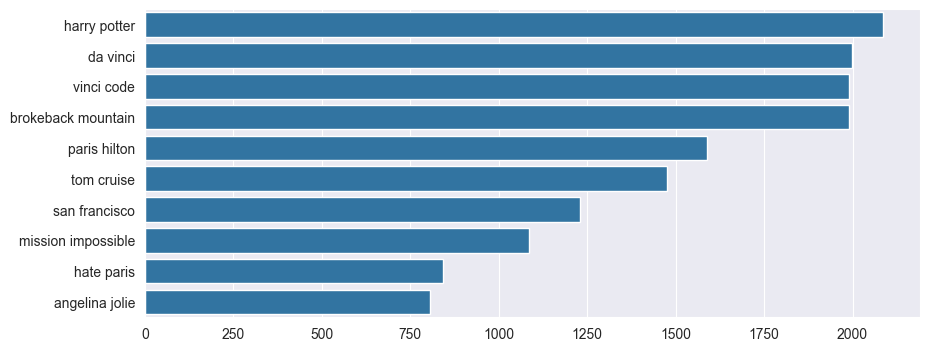

In [19]:
plt.figure(figsize = (10,4))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

**Trigram Analysis**

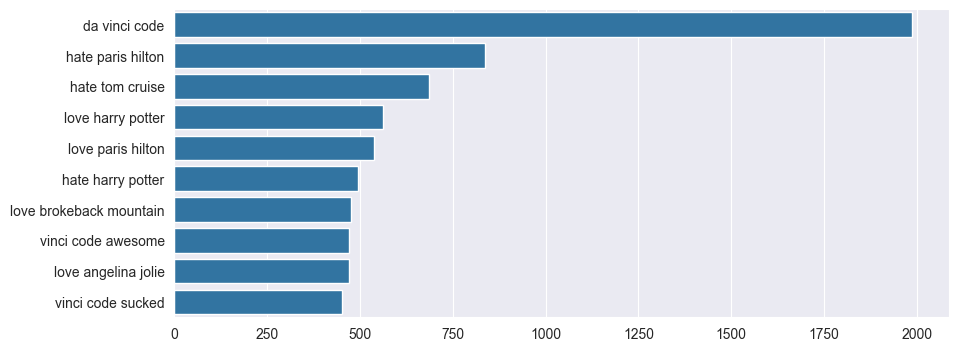

In [20]:
plt.figure(figsize = (10,4))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
plt.show()

### Lemmatizer

In [21]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [22]:
nltk.download('wordnet')
df['text_clean'] = df['text'].apply(lemm_text)
df.head()

[nltk_data] Downloading package wordnet to C:\Users\Anubhav
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,text,text_clean
0,0,history goes back summer san francisco giants...,history go back summer san francisco giant te...
1,0,american express customer service sucks,american express customer service suck
2,1,wow xp macbook would awesome,wow xp macbook would awesome
3,1,love paris hilton britney spears jessica simpson,love paris hilton britney spear jessica simpson
4,1,da vinci code awesome cant wait read,da vinci code awesome cant wait read


In [23]:
df = df.drop('text', axis=1)
df = df.rename(columns={'text_clean':'text'})
df2 = df.copy()

### Count Vectorizer

In [24]:
X = df.text
y = df['sentiment']

In [25]:
X.shape, y.shape

((30459,), (30459,))

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', min_df=5)

In [28]:
vect.fit(X_train)

CountVectorizer(min_df=5, stop_words='english')

In [29]:
X_traint = vect.transform(X_train)
X_testt = vect.transform(X_test)

print(X_traint.shape, X_testt.shape)

(21321, 1061) (9138, 1061)


In [30]:
vect.get_feature_names_out()[0:10]

array(['aaa', 'aback', 'able', 'absolutely', 'academy', 'accent',
       'acceptable', 'accord', 'aching', 'acknowledged'], dtype=object)

#### Tf-IDF

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(X_traint)
X_traint_tfidf = tfidf_transformer.transform(X_traint).toarray()
X_testt_tfidf = tfidf_transformer.transform(X_testt).toarray()
print(X_traint_tfidf[20])

[0. 0. 0. ... 0. 0. 0.]


In [32]:
print(X_traint_tfidf.shape)
print(type(X_traint_tfidf))

(21321, 1061)
<class 'numpy.ndarray'>


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [34]:
rfc = RandomForestClassifier()

params = {'n_estimators':sp_randint(50, 300),
          'max_features':sp_randint(100, 1061),
          'max_depth': sp_randint(1, 20),
          'min_samples_leaf': sp_randint(1, 50)}

rs = RandomizedSearchCV(rfc, param_distributions=params, n_iter=20,
    scoring='roc_auc', cv=3)

#rs.fit(X_traint_tfidf, y_train)

#rs.best_params_

In [35]:
best_params_ = {'max_depth': 19, 'max_features': 875,
 'min_samples_leaf': 12, 'n_estimators': 286}

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

rfc = RandomForestClassifier(**best_params_)

rfc.fit(X_traint_tfidf, y_train)

y_train_pred = rfc.predict(X_traint_tfidf)
y_train_prob = rfc.predict_proba(X_traint_tfidf)[:,1]

print('Confusion Matrix: ', '\n', confusion_matrix(y_train, y_train_pred))

print('Accuracy of Train: ',  accuracy_score(y_train, y_train_pred))
print('AUC of Train: ', roc_auc_score(y_train, y_train_prob))

y_test_pred = rfc.predict(X_testt_tfidf)
y_test_prob = rfc.predict_proba(X_testt_tfidf)[:,1]

print('\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_test_pred))

print('Accuracy of Test: ',  accuracy_score(y_test, y_test_pred))
print('AUC of Test: ', roc_auc_score(y_test, y_test_prob))

Confusion Matrix:  
 [[ 8761   160]
 [   26 12374]]
Accuracy of Train:  0.9912762065569157
AUC of Train:  0.999778878940955


Confusion Matrix:  
 [[3749   70]
 [  21 5298]]
Accuracy of Test:  0.9900415845918143
AUC of Test:  0.9994206001685303


In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
thresholds[0] = thresholds[0]-1

In [38]:
thresh = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'thresh':thresholds})

In [39]:
thresh

,fpr,tpr,thresh
0,0.000000,0.000000,inf
1,0.000000,0.015604,0.998901
2,0.000000,0.303440,0.998868
3,0.000000,0.304005,0.998839
4,0.000000,0.307765,0.998819
...,...,...,...
350,0.277036,1.000000,0.000449
351,0.281487,1.000000,0.000419
352,0.287248,1.000000,0.000376
353,0.995025,1.000000,0.000318


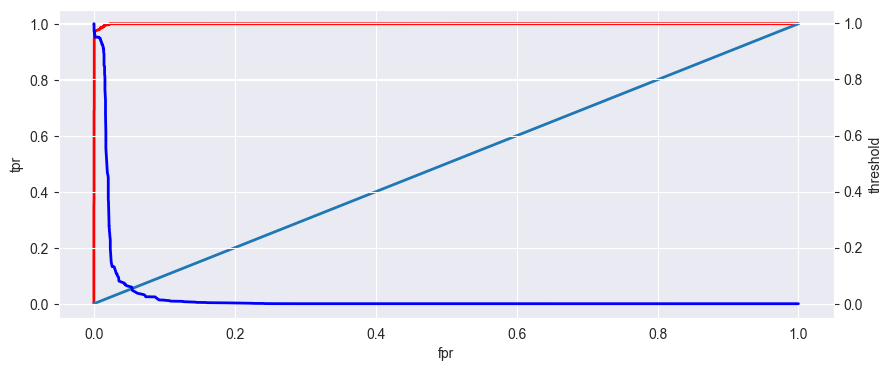

In [40]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(fpr, tpr, lw=2, color='r')
ax.plot(fpr, fpr, lw=2)
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')

ax2 = ax.twinx()
ax2.plot(fpr, thresholds, lw=2, color='b')
ax2.set_ylabel('threshold')
plt.show()

### Sentiment score from NLTK library

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Anubhav
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [42]:
dfs = df.copy()

In [43]:
def sentiment_analyze(text):
    return sia.polarity_scores(text)

dfs['sentiment'] = dfs['text'].apply(sentiment_analyze)
dfs = dfs['sentiment'].apply(pd.Series)
dfs = dfs[['pos']]

In [44]:
df = pd.concat([df, dfs], axis=1)

In [45]:
df.head()

,sentiment,text,pos
0,0,history go back summer san francisco giant te...,0.000
1,0,american express customer service suck,0.000
2,1,wow xp macbook would awesome,0.840
3,1,love paris hilton britney spear jessica simpson,0.412
4,1,da vinci code awesome cant wait read,0.406


In [46]:
df['pos'] = np.where(df['pos']>=0.5, 1, 0)

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(df['sentiment'], df['pos']))
print('\n')
print('Accuracy comparing actual sentiment score and score from NLTK library')
print(accuracy_score(df['sentiment'], df['pos']))

[[12718    22]
 [ 6134 11585]]


Accuracy comparing actual sentiment score and score from NLTK library
0.7978922485964739


## Using Word Embedding

In [48]:
# Load pre trained Embedding
import gensim.downloader as api

# Load pre-trained GloVe model
glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional embeddings

In [49]:
# Convert text to Embedding
def get_embedding(text, model):
    words = text.split()
    # Get the embeddings for each word in the text
    embeddings = [model[word] for word in words if word in model]
    if not embeddings:
        return np.zeros(model.vector_size)  # return zero vector if no words are in the model
    return np.mean(embeddings, axis=0)  # average embeddings for all words

# Apply the function to your dataframe
df['text_embeddings'] = df['text'].apply(lambda x: get_embedding(x, glove_model))

In [50]:
df['text_embeddings'][0].shape

(100,)

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert embeddings into an array
X_embeddings = np.array(df['text_embeddings'].tolist())

# Example: Padding sequences (if using sequential models)
X_padded = pad_sequences(X_embeddings, padding='post')

In [52]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, df['sentiment'], test_size=0.3, random_state=42)

# Train a model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluate the model
y_pred = rfc.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.728277522433793


In [53]:
# Trying out with Word2vec
word2vec = api.load('word2vec-google-news-300')

In [55]:
df.head()

,sentiment,text,pos,text_embeddings
0,0,history go back summer san francisco giant te...,0,"[0.20757899, 0.21542962, 0.27664873, -0.39816,..."
1,0,american express customer service suck,0,"[-0.225406, 0.1842502, 0.28175002, -0.0783412,..."
2,1,wow xp macbook would awesome,1,"[-0.33392698, 0.1785696, 0.59496003, -0.635482..."
3,1,love paris hilton britney spear jessica simpson,0,"[0.376515, -0.2732427, -0.030031156, -0.208735..."
4,1,da vinci code awesome cant wait read,0,"[-0.061304145, 0.0038980034, 0.19684887, -0.44..."


In [56]:
df['text_embeddings'] = df['text'].apply(lambda x: get_embedding(x,word2vec))

In [57]:
df.head()

,sentiment,text,pos,text_embeddings
0,0,history go back summer san francisco giant te...,0,"[0.050872803, 0.14331055, 0.022949219, 0.10189..."
1,0,american express customer service suck,0,"[-0.03618164, 0.0076660155, 0.06535034, 0.1940..."
2,1,wow xp macbook would awesome,1,"[0.068847656, 0.0033203126, -0.028271485, 0.13..."
3,1,love paris hilton britney spear jessica simpson,0,"[-0.10609654, 0.022411892, -0.019810269, 0.203..."
4,1,da vinci code awesome cant wait read,0,"[0.04638672, -0.02823312, 0.08019365, 0.156738..."


In [61]:
# Convert embeddings to array
X_embeddings = np.array(df['text_embeddings'].to_list())
# Example: Padding sequences (if using sequential models)
X_padded = pad_sequences(X_embeddings, padding='post')

In [62]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, df['sentiment'], test_size=0.3, random_state=42)

# Train a model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluate the model
y_pred = rfc.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.5872182096738893


In [63]:
y_pred_train = rfc.predict(X_train)

In [66]:
accuracy_score(y_train, y_pred_train)

0.5793818301205385

## Using RNN

In [70]:
# Importing required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [72]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [81]:
sequences[0], print(df['text'][0])

history go back summer  san francisco giant terrible


([351, 40, 61, 153, 23, 28, 316, 89], None)

In [82]:
word_index = tokenizer.word_index
word_index['history']

351

In [85]:
len(sequences[0])

8

In [89]:
max_len = [len(x) for x in sequences]
max_len = max(max_len)
max_len

174

In [90]:
X_padded = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, df['sentiment'], test_size=0.3, random_state=42)

In [92]:
# Create an embedding matrix for the word2vec model
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

In [94]:
embedding_matrix.shape

(6686, 300)

In [134]:
X_padded.shape

(30459, 174)

In [100]:
# Build the RNN Model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length = max_len, trainable = False))
model.add(SimpleRNN(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, len(word_index)+1))

c:\Users\Anubhav Prasad\anaconda3\envs\py39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [101]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 6686, 300)      │     2,005,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,060,841 (7.86 MB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 2,005,800 (7.65 MB)

In [121]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9941 - loss: 0.0239 - val_accuracy: 0.9904 - val_loss: 0.0312
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9937 - loss: 0.0242 - val_accuracy: 0.9915 - val_loss: 0.0335
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9948 - loss: 0.0197 - val_accuracy: 0.9910 - val_loss: 0.0330
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9951 - loss: 0.0195 - val_accuracy: 0.9912 - val_loss: 0.0382
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9937 - loss: 0.0255 - val_accuracy: 0.9922 - val_loss: 0.0348


In [126]:
# Evaluate the model
y_pred = model.predict(X_test)
print(y_pred)
y_pred = (y_pred>0.5).astype(int)
print('Accuracy:', accuracy_score(y_test, y_pred))

286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
[[9.9974543e-01]
 [4.0579955e-05]
 [3.0766797e-04]
 ...
 [1.4401028e-04]
 [9.9979800e-01]
 [9.9659365e-01]]
Accuracy: 0.9922302473188882


## Using Deep RNN

In [129]:
# Build the deep RNN model
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(SimpleRNN(128, return_sequences=True))  # First RNN layer with sequences output
model.add(SimpleRNN(64, return_sequences=True))   # Second RNN layer with sequences output
model.add(SimpleRNN(32))                          # Third RNN layer without sequences output
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, len(word_index)+1))

c:\Users\Anubhav Prasad\anaconda3\envs\py39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [130]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 6686, 300)      │     2,005,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 6686, 128)      │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 6686, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,076,201 (7.92 MB)

 Trainable params: 70,401 (275.00 KB)

 Non-trainable params: 2,005,800 (7.65 MB)

In [131]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.8852 - loss: 0.2442 - val_accuracy: 0.9904 - val_loss: 0.0342
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.9924 - loss: 0.0294 - val_accuracy: 0.9866 - val_loss: 0.0460
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9818 - loss: 0.0589 - val_accuracy: 0.9404 - val_loss: 0.1708
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.9876 - loss: 0.0463 - val_accuracy: 0.9902 - val_loss: 0.0377
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9921 - loss: 0.0346 - val_accuracy: 0.9903 - val_loss: 0.0375


In [132]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print('Accuracy:', accuracy_score(y_test, y_pred))

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Accuracy: 0.9902604508645217
